In [ ]:
import itertools
import time
from dataclasses import asdict, astuple, dataclass
from functools import partial
from typing import Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from common import EXPORT_DPI, OUTPUT_DIR, PAPER_WIDTH_IN, setup_plotting
from jk_utils import (
    construct_vandermonde,
    grad_jacobi_polynomial,
    jacobi_gauss_lobatto,
    jacobi_polynomial,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
setup_plotting()

# 2.h
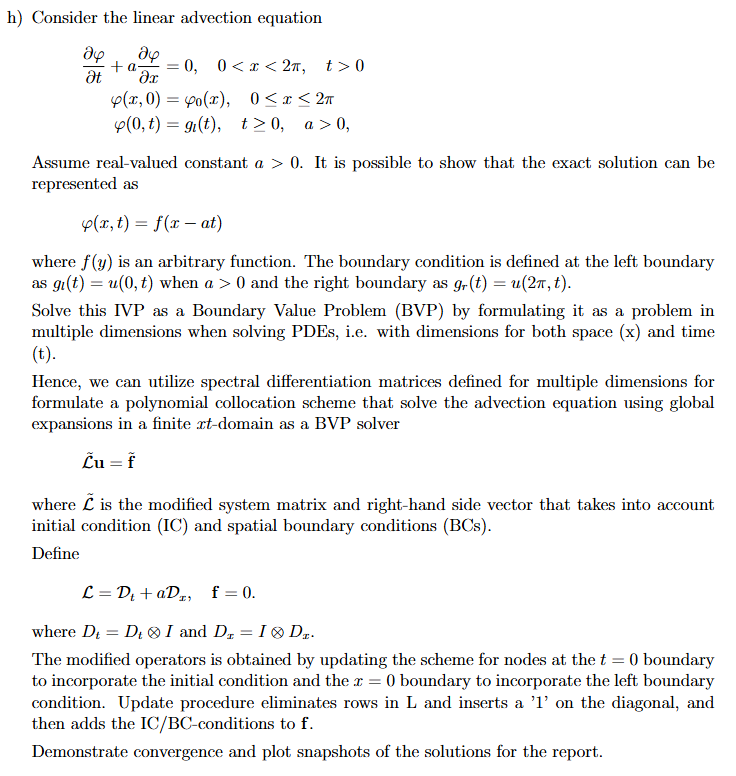

In [8]:
# x = np.linspace(0, 2*np.pi, 1000)
# plt.plot(x, phi(x, t=0.0, a=0.1, c=1.0, x_0=np.pi))

<Figure size 640x480 with 0 Axes>

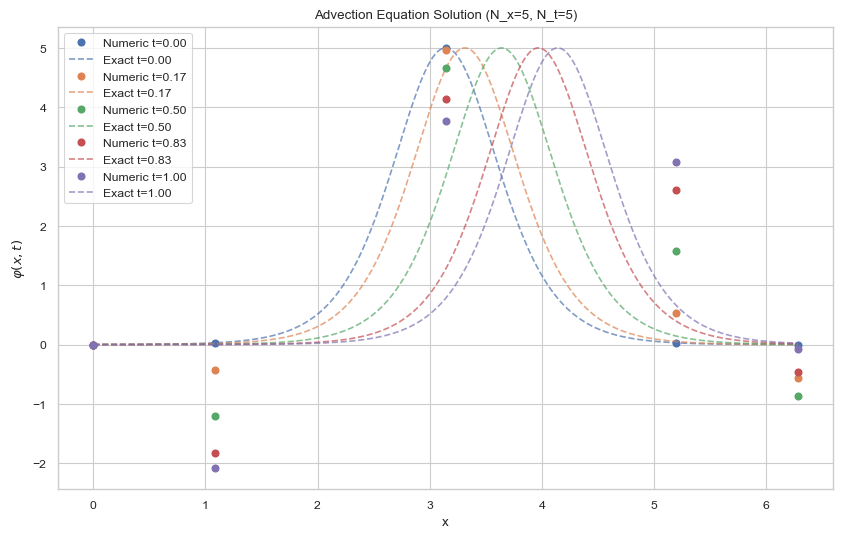

In [17]:
# Function to solve
# Lets just use travelling wave similar to before
def soliton(
    x: npt.NDArray[np.float64], c: float, x_0: float
) -> npt.NDArray[np.float64]:
    sech_argument = np.sqrt(c) * (x - x_0) / 2.0
    f = 1 / 2 * c * (1 / np.cosh(sech_argument)) ** 2

    return f

def phi(x, t, a, c, x_0):
    x_prime = x - a * t
    return soliton(x_prime, c=c, x_0=x_0)

# Solver parameters
alpha_x = 0.0
beta_x = 0.0
alpha_t = 0.0
beta_t = 0.0

# Domain
x_l = 0
x_r = 2 * np.pi
t_0 = 0.0
t_final = 1.0

# Discretisation Parameters
N_x_grid = 5
N_t_grid = 5
# N_x_grid = 32
# N_t_grid = 256
N_x = N_x_grid - 1  # Polynomial degree
N_t = N_t_grid - 1  # Polynomial degree

# x = np.linspace(x_l, x_r, N_x_grid, endpoint=True)
# t = np.linspace(t_0, t_final, N_t_grid, endpoint=True)
x = jacobi_gauss_lobatto(N_x, alpha_x, beta_x)[0] * (x_r - x_l) / 2 + (x_r + x_l) / 2
t = jacobi_gauss_lobatto(N_t, alpha_t, beta_t)[0] * (t_final - t_0) / 2 + (t_final + t_0) / 2

# Map to canonical domain [-1, 1]
z_x = 2 * (x - x_l) / (x_r - x_l) - 1
z_t = 2 * (t - t_0) / (t_final - t_0) - 1

# Problem parameters
a = 1.0  # Advection speed, a > 0
c = 10.0  # Soliton speed
x_0 = 1.0 * np.pi


# Set up basis functions
basis_func_x = partial(jacobi_polynomial, alpha=alpha_x, beta=beta_x)
basis_func_x_grad = partial(grad_jacobi_polynomial, alpha=alpha_x, beta=beta_x)
basis_func_t = partial(jacobi_polynomial, alpha=alpha_t, beta=beta_t)
basis_func_t_grad = partial(grad_jacobi_polynomial, alpha=alpha_t, beta=beta_t)

# Set up differentiation matrices
V_x = construct_vandermonde(z_x, N_x_grid, basis_func_x)
V_x_grad = construct_vandermonde(z_x, N_x_grid, basis_func_x_grad)
D_x_canonical = np.linalg.solve(V_x.T, V_x_grad.T).T  # D_x = V_x_grad * V_x^{-1}, right solve

V_t = construct_vandermonde(z_t, N_t_grid, basis_func_t)
V_t_grad = construct_vandermonde(z_t, N_t_grid, basis_func_t_grad)
D_t_canonical = np.linalg.solve(V_t.T, V_t_grad.T).T  # D_t = V_t_grad * V_t^{-1}, right solve

# Scale differentiation matrices to physical domain
D_x = 2 / (x_r - x_l) * D_x_canonical
D_t = 2 / (t_final - t_0) * D_t_canonical

I_x = np.eye(N_x_grid)
I_t = np.eye(N_t_grid)

D_t_full = np.kron(D_t, I_x)
D_x_full = np.kron(I_t, D_x)

L_n = D_t_full + a * D_x_full
f_n = np.zeros(N_x_grid * N_t_grid)

# Apply boundary and initial conditions
L_n_hat = L_n.copy()
f_n_hat = f_n.copy()

# Apply initial condition at t=0
ic_indices = np.arange(N_x_grid)
L_n_hat[ic_indices, :] = 0.0
L_n_hat[ic_indices, ic_indices] = 1.0
f_n_hat[ic_indices] = phi(x, t=t[0], a=a, c=c, x_0=x_0)

# Apply boundary condition at x=0
bc_indices = np.arange(1, N_t_grid) * N_x_grid
L_n_hat[bc_indices, :] = 0.0
L_n_hat[bc_indices, bc_indices] = 1.0
f_n_hat[bc_indices] = phi(x=x[0], t=t[1:], a=a, c=c, x_0=x_0)

# Solve
u_flat = np.linalg.solve(L_n_hat, f_n_hat)
u_numeric = u_flat.reshape((N_t_grid, N_x_grid))

# Plot solution
X, T = np.meshgrid(x, t)
u_exact = phi(X, T, a=a, c=c, x_0=x_0)

plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
plot_time_indices = np.linspace(0, N_t_grid - 1, 5, dtype=int)
x_fine = np.linspace(x_l, x_r, 1000)
for k in plot_time_indices:
    t_k = t[k]
    u_exact_fine = phi(x_fine, t=t_k, a=a, c=c, x_0=x_0)
    line = ax.plot(x, u_numeric[k, :], 'o', label=f'Numeric t={t_k:.2f}')
    ax.plot(x_fine, u_exact_fine, '--', label=f'Exact t={t_k:.2f}', alpha=0.7, color=line[0].get_color())

ax.set_title(f"Advection Equation Solution (N_x={N_x_grid}, N_t={N_t_grid})")
ax.set_xlabel("x")
ax.set_ylabel("$φ(x,t)$")
ax.legend()
ax.grid(True)
plt.show()



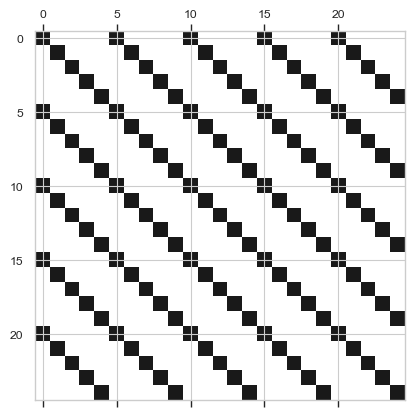

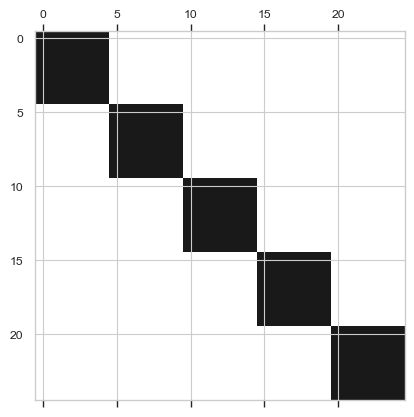

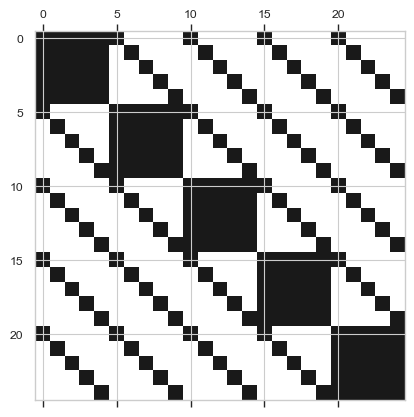

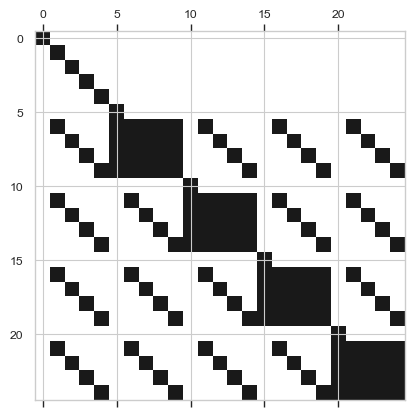

In [20]:
plt.figure()
plt.spy(D_t_full)

plt.figure()
plt.spy(D_x_full)

plt.figure()
plt.spy(L_n)

plt.figure()
plt.spy(L_n_hat)